In [1]:
#!/usr/bin/env python3

import tables
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def with_AreaKey(angular_error, Effective_area):
    val = (np.sum(Effective_area/4*np.pi*angular_error**2))**(1/2)
    return val

In [3]:
import numpy as np

def get_binned_data(xdata, ang_error, aeff, nbins=11, quant=68, logspace=True):
    """
    Parameters:
    - xdata: np.array
        Energy values.
    - ang_error: np.array
        Corresponding percentage error for each energy value.
    - aeff: np.array
        Effective area corresponding to each energy value.

    Returns:
    - centers: np.array
        Bin centers.
    - merit_numbers: np.array
        Merit numbers calculated for each bin.

    Note:
    - Merit number is calculated using a pre-defined function with_AreaKey.
    """
    if logspace:
        bins = np.logspace(np.log10(np.min(xdata)), np.log10(np.max(xdata)), nbins)
    else:
        bins = np.linspace(np.min(xdata), np.max(xdata), nbins)
    
    centers = (bins[1:] + bins[:-1]) / 2.0
    
    merit_numbers = []
    
    for i in range(len(bins) - 1):
        lower, upper = bins[i], bins[i+1]
        mask = (xdata >= lower) & (xdata < upper)
        
        energy_distribution = xdata[mask]
        ang_error_distribution = ang_error[mask]
        aeff_distribution = aeff[mask]
        
        merit_number = with_AreaKey(ang_error_distribution, aeff_distribution)
        
        merit_numbers.append(merit_number)
    
    return centers, np.array(merit_numbers)

## Data preprocessing

In [4]:
# slashes have to be backwards in path
#f = tables.open_file("C:/Users/brayd/Documents/single_muons_muongun_reco_spline_sim0002_waterfits_EffectiveArea.hdf5")
#f.root

In [5]:
# slashes have to be backwards in path
f = tables.open_file("single_muons_muongun_reco_spline_sim0002_waterfits_EffectiveArea.hdf5")
#f.root

In [6]:
data_dict = {
    'angular_error_mmsreco': np.degrees(f.root.angular_error_LLHFit_mmsreco.cols.value[:]),
    'MuonEffectiveArea': f.root.MuonEffectiveArea.cols.value[:],
    'muon_energy': f.root.muon_energy.cols.value[:],
    'dirTrackLengthA_reco': f.root.track_length.cols.value[:]
}

In [7]:
df = pd.DataFrame(data_dict)
df

,angular_error_mmsreco,MuonEffectiveArea,muon_energy,dirTrackLengthA_reco
0,0.135597,9.734735e+10,82413.121514,257.512445
1,34.695274,6.004455e+10,50449.818443,135.333762
2,11.100694,2.364044e+11,201565.655862,NaN
3,2.103542,7.693895e+10,64925.967136,238.682905
4,35.217937,8.055803e+09,5902.700981,177.183219
...,...,...,...,...
58981,0.009737,2.236337e+11,190622.926582,1087.936516
58982,19.961458,3.639989e+10,30189.636449,93.787862
58983,0.050392,1.403944e+11,119298.453314,159.376226
58984,0.021210,1.562260e+11,132863.936810,643.433948


In [8]:
# check for NaNs
print(df.isnull().sum())

angular_error_mmsreco    1811
MuonEffectiveArea           0
muon_energy                 0
dirTrackLengthA_reco     6922
dtype: int64


In [9]:
df = df.dropna()
df

,angular_error_mmsreco,MuonEffectiveArea,muon_energy,dirTrackLengthA_reco
0,0.135597,9.734735e+10,82413.121514,257.512445
1,34.695274,6.004455e+10,50449.818443,135.333762
3,2.103542,7.693895e+10,64925.967136,238.682905
4,35.217937,8.055803e+09,5902.700981,177.183219
5,0.009549,9.633965e+11,824496.665193,938.181358
...,...,...,...,...
58981,0.009737,2.236337e+11,190622.926582,1087.936516
58982,19.961458,3.639989e+10,30189.636449,93.787862
58983,0.050392,1.403944e+11,119298.453314,159.376226
58984,0.021210,1.562260e+11,132863.936810,643.433948


In [10]:
log_bin, merit_number = get_binned_data(xdata = df.muon_energy, 
                                        ang_error= df.angular_error_mmsreco, 
                                        aeff = df.MuonEffectiveArea,
                                        nbins = 11,
                                        logspace=True)

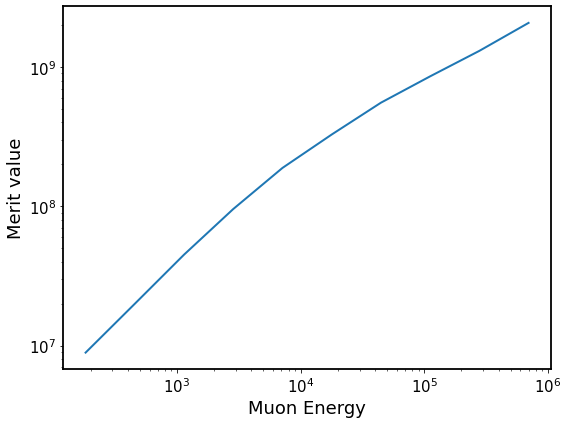

In [11]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(log_bin, merit_number, lw=2)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.8)
    ax.spines[axis].set_color('0.0')
    ax.spines[axis].set_linewidth(1.8)
    ax.spines[axis].set_color('0.0')

ax.set_xlabel("Muon Energy", fontsize=18)
ax.set_ylabel("Merit value", fontsize=18)
    
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

## Plotting per track length

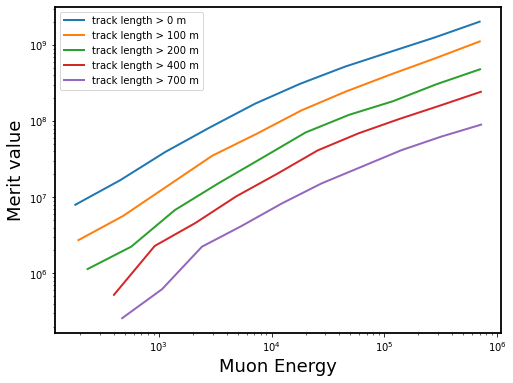

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

for LDir in [0, 100, 200, 400, 700]:
    data = df.loc[(df['dirTrackLengthA_reco'] > LDir)]
    
    log_bin, merit_number = get_binned_data(xdata = data.muon_energy, 
                                        ang_error= data.angular_error_mmsreco, 
                                        aeff = data.MuonEffectiveArea,
                                        nbins = 11,
                                        logspace=True)

    ax.plot(log_bin, merit_number, label = f'track length > {LDir} m', lw=2)
    
    ax.set_xlabel("Muon Energy", fontsize=18)
    ax.set_ylabel("Merit value", fontsize=18)
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.8)
        ax.spines[axis].set_color('0.0')
        ax.spines[axis].set_linewidth(1.8)
        ax.spines[axis].set_color('0.0')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
plt.show()